In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import time
from collections import deque
from random import random
from ipykernel import kernelapp as app
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from numpy.random import choice
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import datasets
from sklearn.metrics import r2_score, accuracy_score , mean_squared_error, log_loss, mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from hyperopt import tpe , hp, Trials , fmin , STATUS_OK , space_eval
import warnings
from functools import partial
warnings.filterwarnings('ignore')

import scipy
from scipy import signal


In [24]:
def generate_random(lb = -0.1, ub = 0.1):
    return (ub-lb)*(np.random.random()) + lb

In [64]:
def datagen():
  x = [ 1,2,3,4,5,6 ]
  if len(x) >0:
    for y in x:
      yield y
      x.append(y)

In [26]:
df = pd.read_csv('../data/shampoo.txt')
df = df.set_index('Month')
print(df.shape)
df.head()

(36, 1)


,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


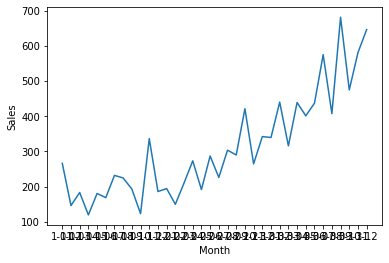

In [27]:
sns.lineplot(df.index,df.Sales)

In [28]:
def double_exponential_smoothing_2(series, alpha=0.5, beta=0.5):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            if len(series)>4:
                level, trend = series[0], (np.sum(series[1:4]) - np.sum(series[0:3]) )/3
            else:
                level, trend = series[0], series[1] - series[0]
#             print(trend, level)
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(np.around(level+trend,1))
    return result

In [29]:
def double_exponential_smoothing(x , a=0.5, g=0.5 ):
    
  res = [np.nan]
  s = [x[0]]
    
  if len(x)>4:
      b = [(np.sum(x[1:4]) - np.sum(x[0:3]) )/3]
  else:
      b = [x[1]-x[0]]
  res.append(s[0]+b[0])
  for t in range(1,len(x)):
    s.append(np.around(a*x[t] + (1-a)*( s[t-1]+b[t-1] ) ,1) )
    b.append( g*(s[t] - s[t-1]) + (1-g)*(b[t-1]) )
    res.append(np.around(s[t]+b[t],1))
  return s , res

In [30]:
x = [ 1 , 2 , 3 , 4 , 5, 6 ,1,2,3,4,5,6,1,2,3,4,5,6,1,2,3,4,5,6]
# x = [6.4,  5.6,  7.8,  8.8,  11,  11.6,  16.7,  15.3,  21.6,  22.4]
# x = [6.4,  5.6, 7.8 , 8.8,  11,  11.6 ]#,  16.7,  15.3,  21.6,  22.4]
print( x , len(x))
print(double_exponential_smoothing(x , 0.3626 , 1.0 )[1])
# print(double_exponential_smoothing_2(x , 0.3626 , 1.0 ))

[1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6, 1, 2, 3, 4, 5, 6] 24
[nan, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 3.6, 1.2, 0.8, 2.1, 4.4, 6.8, 4.4, 2.3, 1.7, 2.4, 4.1, 6.3, 4.0, 2.2, 1.7, 2.5, 4.3, 6.4]


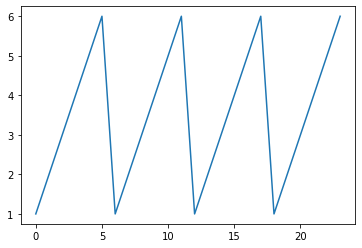

In [31]:
plt.plot(x)

In [32]:
# data = pd.DataFrame({'x':x ,
#                      'ds_': double_exponential_smoothing(x , 0.3626 , 1.0 )[0] ,
#                      'forecast':double_exponential_smoothing(x , 0.3626 , 1.0 )[1][:-1]})
# data

In [60]:
def check_seasonality(series):
    ac = np.correlate( series , series , mode='full' )
    peaks = signal.find_peaks(ac[ac.shape[0]//2:])[0]
    if len(peaks) == 0:
        return None
    return list(peaks)

In [61]:
check_seasonality(x)

[6, 12, 18]

In [73]:
original = deque(maxlen=100)
created = deque(maxlen=100)
forecast = deque(maxlen=100)
i = 0
for item in (datagen()):
    if i >1:
        if i %10== 0:
            seasons = check_seasonality(list(original))
            if isinstance(seasons, list):
                print(seasons)
            else:
                print('No season')
        
        best = func(list(original))
        print(best)
        pred = double_exponential_smoothing(list(original),**best )[1][-1]
        original.append(item)
        created.append(pred)
    else:
        original.append(item)
        created.append(0)
    print( '''forecasted val in the {} th\
          index is {} and actual is {}\
          and the separation is{}'''.format(i, created[i] , original[i], np.around(np.abs(created[i]-original[i])) ))
    i+=1

forecasted val in the 0 th          index is 0 and actual is 1          and the separation is1
forecasted val in the 1 th          index is 0 and actual is 2          and the separation is2
100%|██████████| 100/100 [00:00<00:00, 168.75it/s, best loss: 0.0]
{'a': 0.7634497505165035, 'g': 0.24911086846519115}
forecasted val in the 2 th          index is 3.0 and actual is 3          and the separation is0.0
100%|██████████| 100/100 [00:00<00:00, 160.83it/s, best loss: 0.0]
{'a': 0.9810368600591758, 'g': 0.7673850189896675}
forecasted val in the 3 th          index is 4.0 and actual is 4          and the separation is0.0
100%|██████████| 100/100 [00:00<00:00, 160.34it/s, best loss: 0.0]
{'a': 0.12408610987616808, 'g': 0.714354947312137}
forecasted val in the 4 th          index is 5.0 and actual is 5          and the separation is0.0
100%|██████████| 100/100 [00:00<00:00, 163.74it/s, best loss: 0.0]
{'a': 0.5714584829474384, 'g': 0.33107505705850815}
forecasted val in the 5 th          ind

100%|██████████| 100/100 [00:00<00:00, 136.25it/s, best loss: 4.9750000000000005]
{'a': 0.20846819035174466, 'g': 0.47152358156961716}
forecasted val in the 37 th          index is 3.7 and actual is 2          and the separation is2.0
100%|██████████| 100/100 [00:00<00:00, 143.24it/s, best loss: 4.8924324324324315]
{'a': 0.2679042086213945, 'g': 0.24320999097232535}
forecasted val in the 38 th          index is 3.1 and actual is 3          and the separation is0.0
100%|██████████| 100/100 [00:00<00:00, 139.44it/s, best loss: 4.781578947368422]
{'a': 0.41762186120122247, 'g': 0.1471731016701669}
forecasted val in the 39 th          index is 2.7 and actual is 4          and the separation is1.0
[6, 12, 18, 22, 24, 28]
100%|██████████| 100/100 [00:00<00:00, 133.92it/s, best loss: 4.692820512820513]
{'a': 0.21581768606984508, 'g': 0.43755705593240435}
forecasted val in the 40 th          index is 3.0 and actual is 5          and the separation is2.0
100%|██████████| 100/100 [00:00<00:00, 1

100%|██████████| 100/100 [00:00<00:00, 131.78it/s, best loss: 4.4291549295774635]
{'a': 0.26822140649464254, 'g': 0.2580734644845717}
forecasted val in the 72 th          index is 4.6 and actual is 1          and the separation is4.0
100%|██████████| 100/100 [00:00<00:00, 125.06it/s, best loss: 4.4776388888888885]
{'a': 0.19986263916765806, 'g': 0.332099298685435}
forecasted val in the 73 th          index is 3.6 and actual is 2          and the separation is2.0
100%|██████████| 100/100 [00:00<00:00, 121.80it/s, best loss: 4.491917808219179]
{'a': 0.20256186410903207, 'g': 0.2894571538420579}
forecasted val in the 74 th          index is 3.2 and actual is 3          and the separation is0.0
100%|██████████| 100/100 [00:00<00:00, 119.62it/s, best loss: 4.409594594594595]
{'a': 0.1897117616956895, 'g': 0.3610705310058435}
forecasted val in the 75 th          index is 3.1 and actual is 4          and the separation is1.0
100%|██████████| 100/100 [00:00<00:00, 115.24it/s, best loss: 4.3918

KeyboardInterrupt: 

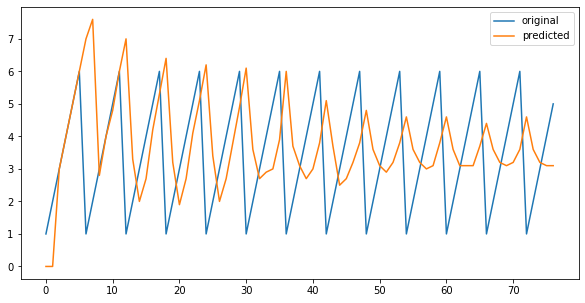

In [74]:
figure = plt.figure(figsize=(10,5))
plt.plot(original , label='original' )
plt.plot( created, label = 'predicted' )
plt.legend()

In [39]:
# compute_cost_cross({'a':hp.uniform('a', 0,1 ) , 'g':hp.uniform('g', 0,1) }, )

In [40]:
# cost = partial(compute_cost_cross , X = df.Sales )

In [41]:
def compute_cost_cross(args,X):
    y = double_exponential_smoothing(X, **args)[1][1:-1]
    loss = mean_squared_error( X[1:] ,y )   
    return loss

def func(x):
    cost = partial(compute_cost_cross , X = x )
    tr = Trials()
    best = fmin(cost,
        {'a':hp.uniform('a', 0,1 ) , 'g':hp.uniform('g', 0,1) },
        algo=tpe.suggest,
        max_evals=100 ,
        trials=tr)
    return best

In [42]:
best = func(df.Sales)

100%|██████████| 100/100 [00:00<00:00, 119.06it/s, best loss: 7232.181428571428]


In [43]:
print(best)

{'a': 0.3489202634165264, 'g': 0.3368934295572774}


In [46]:
# losses = [ x['loss'] for x in tr.results ]
# min_index = np.argmin( losses )

In [47]:
# min_index, losses[min_index]

In [20]:
1284*9

11556

In [22]:
(145/11556)*100

1.2547594323295257

In [58]:
from scipy.signal import correlate

In [59]:
correlate(x,x)

array([  6,  17,  32,  50,  70,  91,  82,  84,  96, 117, 146, 182, 158,
       151, 160, 184, 222, 273, 234, 218, 224, 251, 298, 364, 298, 251,
       224, 218, 234, 273, 222, 184, 160, 151, 158, 182, 146, 117,  96,
        84,  82,  91,  70,  50,  32,  17,   6])